# Identifying A Simple Rational Function Using SINDy Algorithm

Objectives:

1. Simulate the Michaelis-Menten kinetics model for an enzymatic reaction
2. Identify a nonlinear ODE from the data (using SINDy extension for rational function nonlinearities)
2. Test the model on additional data
3. See if noise affects the model

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import sindy
import enzyme
from importlib import reload
reload(enzyme)

%matplotlib inline

In [2]:
data_dir = '../../data'
plot_dir = '../../plots'

### Generate Data by Simulating System

- The Michaelis-Menten kinetics model of enzymatic reactions

This example is the example presented by Niall Mangan in the paper
"Inferring biological networks by sparse identification of 
nonlinear dynamics" by N. M. Mangan, S. L. Brunton, J. L. Proctor,
and J. N. Kutz.

In [3]:
# Size of system
n = 1

# Rate constants
v_max = 1.5  # maximum reaction rate
k_m = 0.3    # half max reaction rate
j_in = 0.6   # influx of substrate

# Simulation settings
measures = 2  # number of initial conditions
dt = 0.1     # time step
T = 4        # Duration
tspan = np.arange(0, T + dt, dt)  # time vector
N = len(tspan)

# Initial conditions
x0 = (0.5, 1)

# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab
fun = partial(enzyme.mmkinetics, v_max=v_max, k_m=k_m, j_in=j_in)
rtol = 1e-7
atol = 1e-7 * np.ones_like(x0)
x_data = odeint(fun, x0, tspan, tfirst=True, rtol=rtol, atol=atol)
assert x_data.shape == (N, measures)

# Calculate derivatives
dxdt_data = fun(tspan, x_data)
assert dxdt_data.shape == (N, measures)

x_data.shape, dxdt_data.shape

((41, 2), (41, 2))

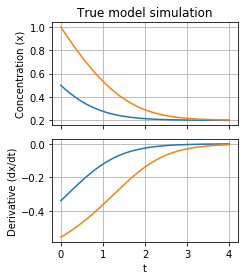

In [4]:
fig, axes = plt.subplots(2, 1, sharex=True,
                         figsize=(3.5, 4))

ax = axes[0]
ax.plot(tspan, x_data)
ax.set_ylabel('Concentration (x)')
ax.set_title('True model simulation')
ax.grid()

ax = axes[1]
ax.plot(tspan, dxdt_data)
ax.set_xlabel('t')
ax.set_ylabel('Derivative (dx/dt)')
ax.grid()

filepath = os.path.join(plot_dir, 'mm-kinetics-x-plot.pdf')
plt.tight_layout()
plt.savefig(filepath)
plt.show()

In [5]:
# Add noise & calculate derivative
rng = np.random.RandomState(seed=1)

eps = 1e-4  # noise magnitude for x data
eps_dt = 0   # noise magnitude for dx/dt data

# Normally distributed measurement error
x_data_noisy = x_data + eps * rng.randn(*x_data.shape)

dxdt_data_noisy = dxdt_data + eps_dt * rng.randn(*dxdt_data.shape)

x_data_noisy.shape, dxdt_data_noisy.shape

((41, 2), (41, 2))

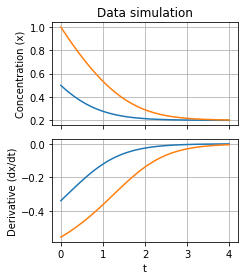

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True,
                         figsize=(3.5, 4))

ax = axes[0]
ax.plot(tspan, x_data_noisy)
ax.set_ylabel('Concentration (x)')
ax.set_title('Data simulation')
ax.grid()

ax = axes[1]
ax.plot(tspan, dxdt_data_noisy)
ax.set_xlabel('t')
ax.set_ylabel('Derivative (dx/dt)')
ax.grid()

filepath = os.path.join(plot_dir, 'mm-kinetics-x-plot-noise.pdf')
plt.tight_layout()
plt.savefig(filepath)
plt.show()

In [7]:
# Combine data from each simulation into one dataset
xt = x_data_noisy.swapaxes(0, 1).reshape(-1, 1)
dxdt = dxdt_data_noisy.swapaxes(0, 1).reshape(-1, 1)
t = np.tile(tspan, measures).reshape(-1, 1)

assert xt.shape == (N*measures, n)
assert dxdt.shape == xt.shape
assert t.shape == (N*measures, n)
xt.shape, dxdt.shape, t.shape

((82, 1), (82, 1), (82, 1))

In [8]:
xt[:5]

array([[0.50016243],
       [0.46738843],
       [0.43736348],
       [0.409683  ],
       [0.38414576]])

In [9]:
dxdt[:5]

array([[-0.3375    ],
       [-0.3136359 ],
       [-0.2896459 ],
       [-0.26575814],
       [-0.24221475]])

In [10]:
dxdt[40:45]

array([[-0.00073341],
       [-0.55384615],
       [-0.53866084],
       [-0.52257753],
       [-0.50556857]])

In [11]:
# Make them into dataframes
t_df = pd.Series(tspan, name='t')
xt_df = pd.DataFrame(
    {f'x{i}': xt[:, i] for i in range(xt.shape[1])}
)
dxdt_df = pd.DataFrame(
    {f'dxdt{i}': dxdt[:, i] for i in range(dxdt.shape[1])}
)

# Combine into one dataframe including time
df = pd.concat([t_df, xt_df, dxdt_df], axis=1)
assert df.shape == (N*measures, 1 + n*2)
df.head()

,t,x0,dxdt0
0,0.0,0.500162,-0.337500
1,0.1,0.467388,-0.313636
2,0.2,0.437363,-0.289646
3,0.3,0.409683,-0.265758
4,0.4,0.384146,-0.242215


In [12]:
# Create the data for function library
# Does not have be the same as the functions we used to generate the data
#laurentorder = 0  # n, for 1/x**n terms in the library
polyorder = 3  # n, for polynomial terms in the library x^n
#usesine = 0  # adds sine to the library
#dyorder = 1  # n for (dx/dt)**n terms in the library

# Build libraries of polynomial terms for numerator and demoninator
theta_n, labels_n = sindy.polynomial_features(xt, order=polyorder, include_labels=True)
theta_d, labels_d  = theta_n, labels_n   # Make it same as numerator polynomial
theta_n.shape, labels_n

((82, 4), ['1', 'x0', 'x0**2', 'x0**3'])

In [13]:
# Make the libraries into dataframes
theta_n_df = pd.DataFrame(theta_n, columns=labels_n)
theta_d_df = pd.DataFrame(theta_d, columns=labels_d)

# Construct augmented function library for implicit SINDy
theta = sindy.augmented_feature_library(theta_n_df, theta_d_df, dxdt_df)
theta.shape

(82, 8)

In [14]:
theta.shape

(82, 8)

In [17]:
theta.head()

,1,x0,x0**2,x0**3,1*dxdt0,x0*dxdt0,x0**2*dxdt0,x0**3*dxdt0
0,1.0,0.500162,0.250162,0.125122,-0.337500,-0.168805,-0.084430,-0.042229
1,1.0,0.467388,0.218452,0.102102,-0.313636,-0.146590,-0.068514,-0.032023
2,1.0,0.437363,0.191287,0.083662,-0.289646,-0.126681,-0.055405,-0.024232
3,1.0,0.409683,0.167840,0.068761,-0.265758,-0.108877,-0.044605,-0.018274
4,1.0,0.384146,0.147568,0.056688,-0.242215,-0.093046,-0.035743,-0.013731


In [20]:
tol = 1e-5
xi, indTheta, lambdavec, numterms, errorv = \
    adm.adm_pareto(theta, tol, plot=False)

NameError: name 'adm' is not defined

In [ ]:
# Estimate sparse dynamic model
lamb = 0.025  # sparsification knob lambda
xi = sindy.sparsify_dynamics_lstsq(theta, dxdt, lamb, n)
assert xi.shape == (20, 3)